In [1]:
# Example fitting a standard attenuator out (A0) RHESSI flare (microflare)

# 09-Jul-2024 IGH

In [2]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx
# This work with v0.4.1
from sunkit_spex.fitting_legacy.fitter import Fitter
from sunkit_spex import thermal
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
# Load in the new thermal model CHIANTI files
# Updated lines but also lower resolution temperature binning
thermal.CONTINUUM_GRID=thermal.setup_continuum_parameters('/Users/iain/github/fvth_stuff/better_chxdb/chianti_cont_1_250_unity_v101_t71.sav')
thermal.LINE_GRID=thermal.setup_line_parameters('/Users/iain/github/fvth_stuff/better_chxdb//chianti_lines_1_12_unity_v101_t71.sav')

In [4]:
# plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
#                          'font.sans-serif':"Arial",'mathtext.default':"regular"})

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Ubuntu",'mathtext.default':"regular"})

In [5]:
# Return a string with a trailing 0 if <10
def ldz_int(num):
    if num<10:
        return f'0{int(num):d}'
    if num >=10:
        return f'{int(num):d}'
# Convert astropy time into break_time sswidl format used for the filenames
def break_time(time):
    t=time.ymdhms
    stime=f'{t.year:d}'+ldz_int(t.month)+ldz_int(t.day)+'_'+\
        ldz_int(t.hour)+ldz_int(t.minute)+ldz_int(t.second)
    return stime

In [6]:
# Use the genx file info for the times and the filename
res=read_genx('../wee_fig9.genx')
nf=len(res["SAVEGEN0"])
ftims=[]
btims=[]
fname=[]

for f in range(nf):
    ftims.append(Time(res["SAVEGEN0"][f]["FPEAK_TR"],format='isot'))
    btims.append(Time(res["SAVEGEN0"][f]["BK_BF_TR"],format='isot'))
    # spec and srm fits are bk_bf_tr[0]-4s    
    # tt=Time(res["SAVEGEN0"][f]["BK_BF_TR"],format='isot')[0]-TimeDelta(16,format='sec')
    tt=Time(res["SAVEGEN0"][f]["FPEAK"],format='isot')

    fname.append(break_time(tt))


In [7]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,30], [5e-2,3e4]
tol = 1e-5

fdir="/Users/iain/github/rhessi_spectra/shi_ex/"
_dir = "/Users/iain/github/rhessi_spectra/mfstats9_fits/"

In [8]:
id=3
# use the summed over 6 detectors
spec = Fitter(pha_file=_dir+fname[id]+"_spec_sum_org.fits", 
                srm_file=_dir+fname[id]+"_srm_sum_org.fits")

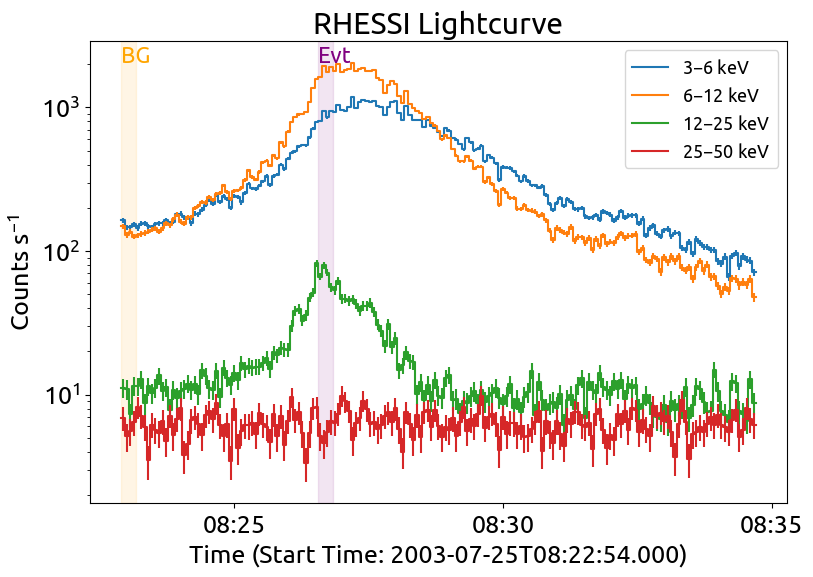

In [9]:
# background time. Both need to be set, if one is None (default) then no background will be calculated or will be removed
spec.data.loaded_spec_data['spectrum1'].start_background_time = btims[id].isot[0][:19]
spec.data.loaded_spec_data['spectrum1'].end_background_time = btims[id].isot[1][:19]

# event time
spec.data.loaded_spec_data['spectrum1'].start_event_time = ftims[id].isot[0][:19]
spec.data.loaded_spec_data['spectrum1'].end_event_time = ftims[id].isot[1][:19]

# plot again
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
spec.data.loaded_spec_data['spectrum1'].lightcurve(energy_ranges=[[3,6], [6,12], [12,25],[25,50]])
plt.show()
plt.rcParams['font.size'] = default_font_size

In [10]:
spec.model = "f_vth+thick_fn"
spec.loglikelihood = "cstat"
# spec.loglikelihood = "poisson" # This shouldn't be used with RHESSI data....
# spec.show_params

In [11]:
# Just fit thermal part first and set the bounds
spec.energy_fitting_range = [4,8]
spec.params["T1_spectrum1"] = {"Value":10, "Bounds":(7, 20)}
spec.params["EM1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e2)}
spec.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-2, 1e2)}
spec.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(3, 12)}
spec.params["e_c1_spectrum1"] = {"Status":"fix", "Value":15, "Bounds":(7, 30)}
spec_fit = spec.fit()

# Then non-thermal fit higher energy
spec.energy_fitting_range = [8,15]
spec.params["T1_spectrum1"] = "fix"
spec.params["EM1_spectrum1"] = "fix"
spec.params["total_eflux1_spectrum1"] = "free"
spec.params["index1_spectrum1"] = "free"
spec.params["e_c1_spectrum1"] = "free"
spec_fit = spec.fit()

# The do the full range
spec.energy_fitting_range = [4,15]
spec.params["T1_spectrum1"] = "free"
spec.params["EM1_spectrum1"] = "free"
spec.params["total_eflux1_spectrum1"] = "free"
spec.params["index1_spectrum1"] = "free"
spec.params["e_c1_spectrum1"] = "free"
spec_fit = spec.fit()


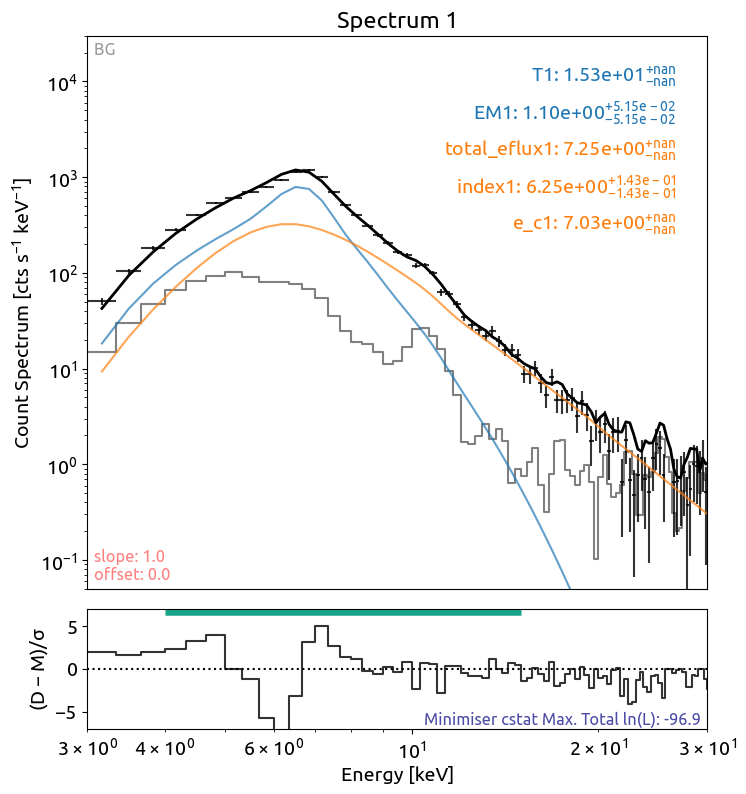

In [12]:
# Remember that sunxspex plots the background and data, 
# whereas ospex did background and data-background
# So total model black line is thermal+non-thermal+background

plt.rcParams['font.size'] = 14
plt.figure(figsize=[8,9])
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()


In [13]:
mcmc_result = spec.run_mcmc(steps_per_walker=1000,walker_spread='mag_order')

100%|██████████| 1000/1000 [04:04<00:00,  4.10it/s]


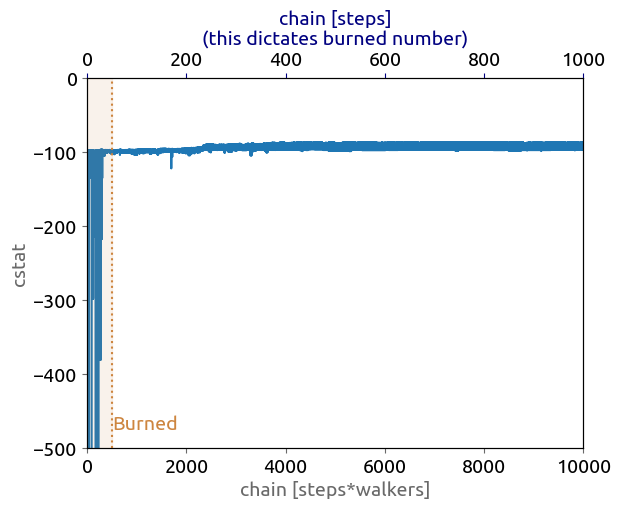

In [14]:
spec.burn_mcmc = 50
plt.figure()
spec.plot_log_prob_chain()
plt.ylim([-500,0])
plt.show()

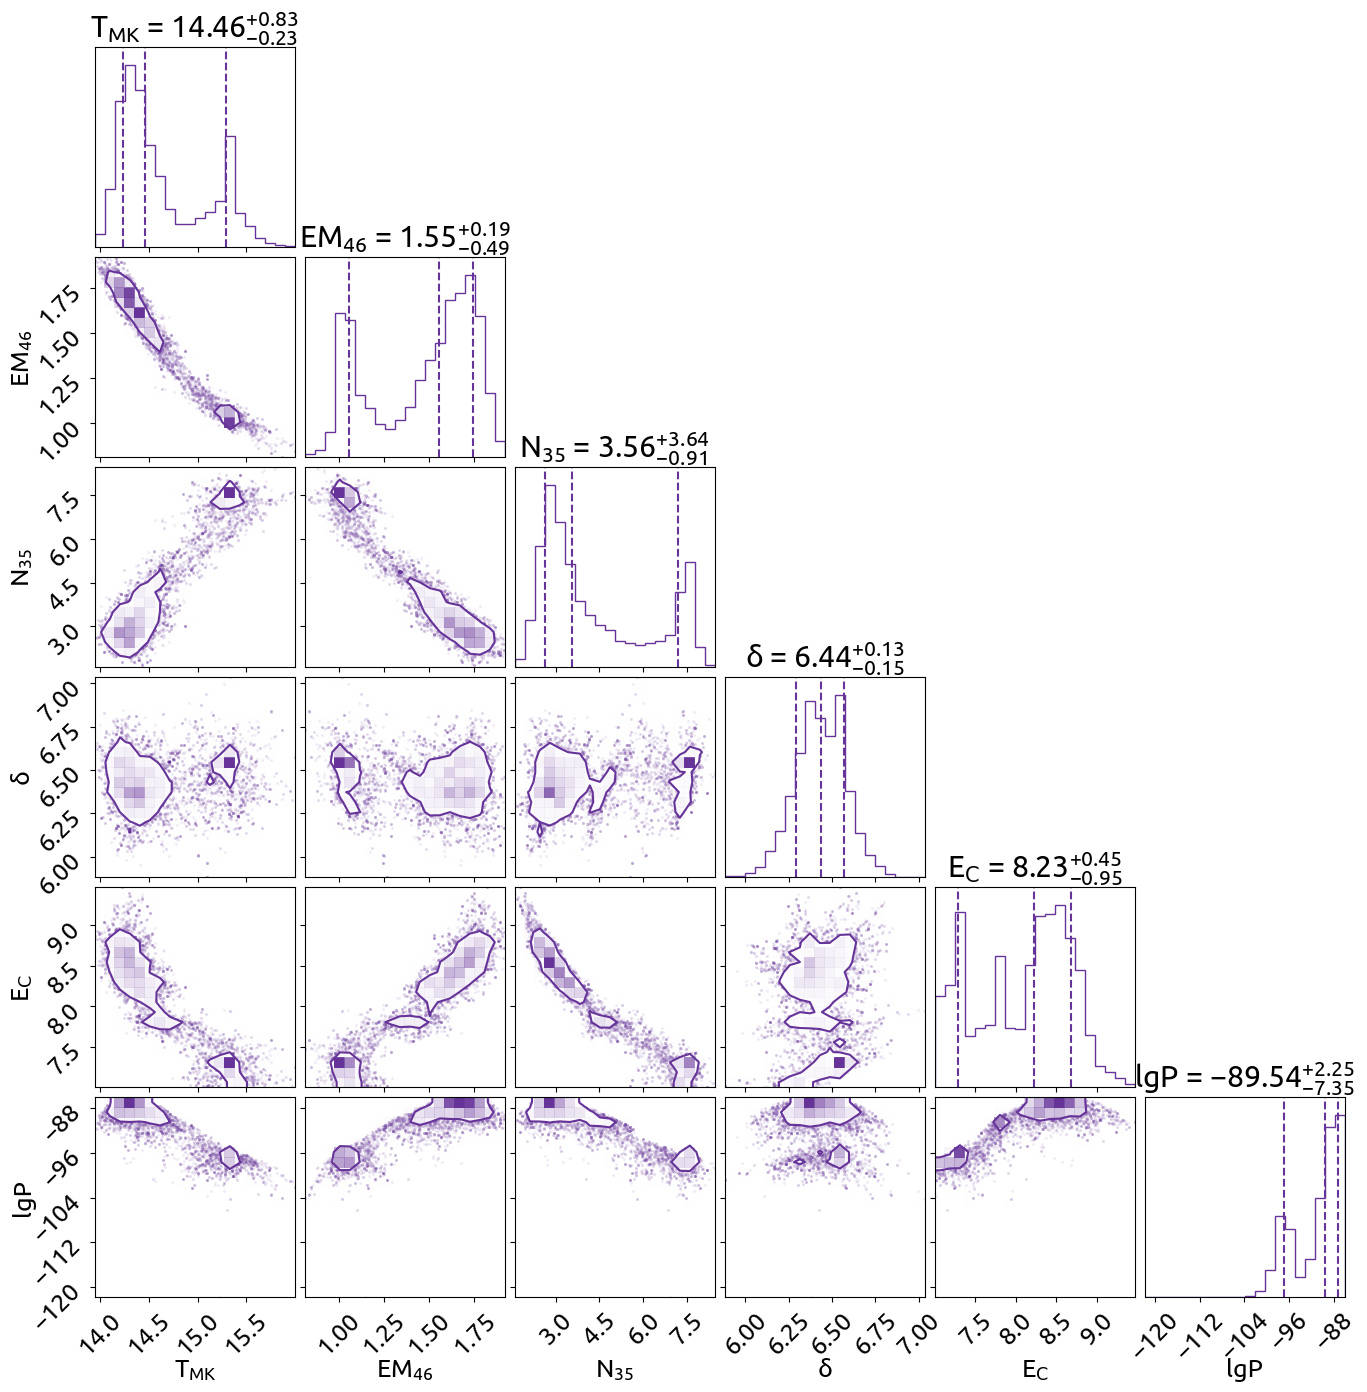

In [15]:
plt.rc('font', family='sans-serif', weight='normal', size=18)
# plt.figure(figsize=[4,4])
corner_plot = spec.corner_mcmc(labels=['$T_{MK}$','$EM_{46}$','$N_{35}$','$\delta$','$E_\mathrm{C}$','lgP'],\
                               color='rebeccapurple',_fix_titles=False,title_fmt='.2f',show_titles=True)
plt.savefig('20030725_vth_thick2_cornerv10.pdf',bbox_inches='tight')
plt.show()


In [16]:
# plt.rcParams['font.size'] = 14
# plt.figure(figsize=[8,9])
# axes, res_axes = spec.plot()
# for a in axes:
#     a.set_xlim(xlims)
#     a.set_ylim(ylims)
#     a.set_xscale("log")
# plt.show()


In [17]:
# Note this only work in the current version of sunxspex.....
# Get all the fit parameters
tmk=spec.params["T1_spectrum1"]['Value']
tmk_ci=[tmk-spec.params["T1_spectrum1"]['Error'][0],tmk+spec.params["T1_spectrum1"]['Error'][1]]
em=spec.params["EM1_spectrum1"]['Value']*1e46
em_ci=[em-spec.params["EM1_spectrum1"]['Error'][0]*1e46,\
    em+spec.params["EM1_spectrum1"]['Error'][1]*1e46]
ntot=spec.params["total_eflux1_spectrum1"]["Value"]*1e35
ntot_err=[spec.params["total_eflux1_spectrum1"]["Error"][0]*1e35,\
          spec.params["total_eflux1_spectrum1"]["Error"][1]*1e35]
ind=spec.params["index1_spectrum1"]["Value"]
ind_err=[spec.params["index1_spectrum1"]["Error"][0],spec.params["index1_spectrum1"]["Error"][1]]
ec=spec.params["e_c1_spectrum1"]["Value"]
ec_err=[spec.params["e_c1_spectrum1"]["Error"][0],spec.params["e_c1_spectrum1"]["Error"][1]]

# Make them look nice for the plot
tmks=f'{tmk:4.2f}'
tmkups=f'{tmk_ci[1]-tmk:4.2f}'
tmkdns=f'{tmk-tmk_ci[0]:4.2f}'
ems=f'{em*1e-46:4.2f}'
emups=f'{(em_ci[1]-em)*1e-46:4.2f}'
emdns=f'{(em-em_ci[0])*1e-46:4.2f}'
nts=f'{ntot*1e-35:4.2f}'
ntups=f'{ntot_err[1]*1e-35:4.2f}'
ntdns=f'{ntot_err[0]*1e-35:4.2f}'
inds=f'{ind:4.2f}'
indups=f'{ind_err[1]:4.2f}'
inddns=f'{ind_err[0]:4.2f}'
ecs=f'{ec:4.2f}'
ecups=f'{ec_err[1]:4.2f}'
ecdns=f'{ec_err[0]:4.2f}'

# Get the data and fits to replot
engs=spec.plotting_info['spectrum1']['count_channels']
edels=spec.plotting_info['spectrum1']['count_channel_error']
rat=spec.plotting_info['spectrum1']['count_rates']
erat=spec.plotting_info['spectrum1']['count_rate_errors']
# Currently background returns same values twice ?!?!?! like resid
backrat=spec.plotting_info['spectrum1']['background_rate'][::2]
resid=spec.plotting_info['spectrum1']['residuals'][::2]
fmd=spec.plotting_info['spectrum1']['count_rate_model']
sfmd=spec.plotting_info['spectrum1']['submodels']
fiter=spec.plotting_info['spectrum1']['fitting_range']
# Sort out the energy binning steps for plotting
stepe = list()
for i in range(len(engs)):
    stepe.append(engs[i] - edels[i])
stepe.append(engs[-1]+edels[-1])
ns=len(stepe)

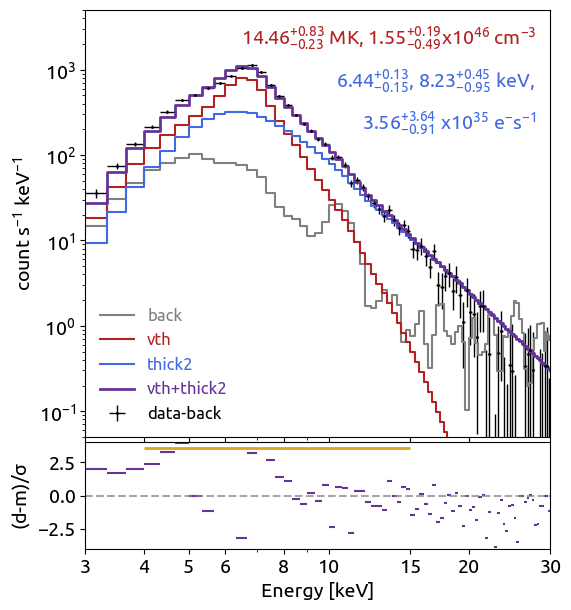

In [18]:
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Ubuntu",'mathtext.default':"regular"})
plt.rc('font', family='sans-serif', weight='normal', size=14)
# Do the more standard plot of data-background
# Now do a nicer plot with x-axis log labels again
yrlim=[-4,4]
ylims=[5e-2,5e3]
xlim=[3,30]
gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
                             gridspec_kw=gs_kw,figsize=(6,7))

axs[0].errorbar(engs,rat-backrat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='data-back')
axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='vth')
axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='thick2')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1]+sfmd[1][0:ns-1],where='post',color='rebeccapurple',lw=2,label='vth+thick2')
axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
            ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
              color='firebrick',ha='right',transform=axs[0].transAxes)

axs[0].text(0.97,0.82,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
            ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.72,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
axs[0].set_xlabel(" ")
axs[0].set_yscale("log")
axs[0].set_ylim(ylims)


axs[1].set_ylabel("(d-m)/$\sigma$")
axs[1].set_ylim(yrlim)
axs[1].set_xlabel("Energy [keV]")
axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='goldenrod',lw=2)

for aaxx in axs:
    aaxx.set_xlim(xlim)
    aaxx.set_xscale("log")
    aaxx.set_xticks([3,4,5,6,8,10,15,20,30])
    aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels([])
plt.savefig('20030725_vth_thick2_exv10.pdf',bbox_inches='tight')
plt.show()